# Colormesh plot
---
This notebook generates plots for selected atoms and epochs. 

For example, choosing `Si` will show the effect of all the silicon ions available from Chianti (and computed previously) on the baseline Kurucz spectrum.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from glob import glob

plt.style.use('seaborn-white')

In [2]:
EPOCH = '20d'  # Select one epoch per run
ATOM = 'Si' 
XRANGE = (2000, 10000)

In [3]:
fnames = glob("output/{}/*_{}_?_{}.h5".format(EPOCH, ATOM, EPOCH))
fnames.append('output/{}/kurucz_cd23_latest_{}.h5'.format(EPOCH, EPOCH))
fnames = sorted(fnames)

<div class="alert alert-warning">

**IMPORTANT:** Always check `fnames` list before plot!

</div>

In [4]:
fnames

['output/20d/kurucz_cd23_latest_20d.h5',
 'output/20d/kurucz_cd23_latest_chianti_Si_1_20d.h5',
 'output/20d/kurucz_cd23_latest_chianti_Si_2_20d.h5']

In [5]:
def make_plot_data(fname):
    
    keys = pd.HDFStore(fname, mode='r').keys()
    data = {k.strip('/'):pd.read_hdf(fname, k) for k in keys} 
    
    return data

In [6]:
def residual_vector(file_1, file_2):
    data_1 = make_plot_data(file_1)
    data_2 = make_plot_data(file_2)
    residual = 100*(data_2['luminosity_density_lambda']-data_1['luminosity_density_lambda'])\
                    /data_1['luminosity_density_lambda']            
    return residual.values

# Using `matplotlib.pyplot.pcolormesh`

In [7]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [8]:
residual = sum([ np.abs(residual_vector(fnames[0], fname)) for fname in fnames[1:]])
#residual = np.abs(residual)  # the order of `abs()` and `sum()` need to be discussed

baseline = make_plot_data(fnames[0])

In [9]:
cmap = mpl.cm.viridis  # (1) 
cmaplist = [cmap(i) for i in range(cmap.N)]  # extract colors from cmap
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'custom_cmap', cmaplist, cmap.N)

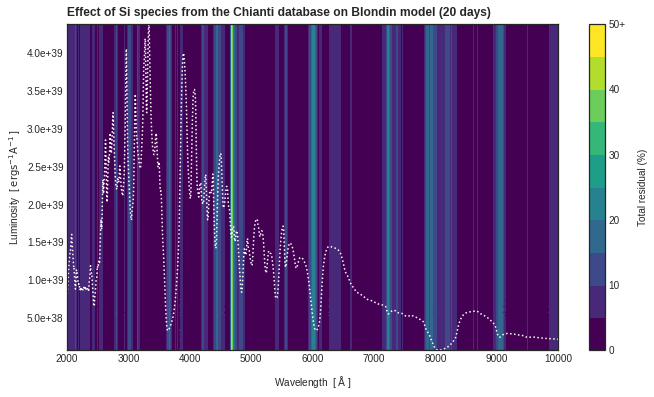

In [10]:
# Replace xlim by calculating the indexes for faster `pcolormesh`
idx1 = (np.abs(baseline['wavelength'] - XRANGE[1])).idxmin()
idx2 = (np.abs(baseline['wavelength'] - XRANGE[0])).idxmin()
slc = slice(idx1, idx2)

x = baseline['wavelength'][slc]
y = baseline['luminosity_density_lambda'][slc]
z = [residual[slc] for z in range(idx1, idx2)]

max_bound = 50
step = 5
bounds = np.linspace(0, max_bound, int(max_bound/step +1))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

sci_formatter = lambda x, lim: '0' if x == 0 else '{:.1e}'.format(x)
y_format = FuncFormatter(sci_formatter)

#decimal_formatter = lambda x, lim: '0' if x == 0 else '{:.2f}'.format(x)
percent_formatter = lambda x, lim: str(int(x)) if x != max_bound else '{}+'.format(max_bound)
cb_format = FuncFormatter(percent_formatter)

fig, ax = plt.subplots(figsize=(11,6))
ax.set_xlabel('Wavelength  [ $\mathrm{\AA}$ ]', labelpad=10)
ax.set_ylabel(r'Luminosity  [ $\mathrm{erg} \mathrm{s}^{−1} \mathrm{A}^{−1}}$ ]')

ax.plot(x, y, c='white', lw=1.5, ls=':')
#ax.plot(x, y, c='black', lw=1.25, ls='-', label = 'Baseline spectrum')
ax.yaxis.set_major_formatter(y_format)
ax.set_xlim(XRANGE[0], XRANGE[1])
#ax.legend(frameon=True, handlelength=1.5)

cm = ax.pcolormesh(x, y, z, cmap=cmap, norm=norm)
cb = fig.colorbar(cm, format=cb_format)
cb.set_label('Total residual (%)', labelpad=12)

plt.title('Effect of {} species from the Chianti database on Blondin model ({} days)'.format(ATOM, EPOCH.strip('d')), pad=8, fontweight="bold", loc='left')
plt.savefig('img/{}_{}.png'.format(ATOM, EPOCH))